# Google Gemini API with Kotlin

This notebook demonstrates how to use the Google Gemini API with Kotlin through the Google GenAI Java SDK.

## Introduction to Google Gemini

Google Gemini is a family of multimodal large language models (LLMs) developed by Google DeepMind. These models are designed to understand and generate content across different modalities including text, images, audio, video, and code. Gemini models excel at complex reasoning tasks, creative content generation, and can process multiple types of information simultaneously.

Key features of Gemini include:

- **Multimodal capabilities**: Can understand and generate content across different formats
- **Advanced reasoning**: Capable of solving complex problems and following nuanced instructions
- **Code generation and understanding**: Strong performance on programming tasks
- **Real-time interaction**: Support for streaming responses for interactive applications
- **Image generation**: Ability to create and modify images based on text prompts

This notebook will guide you through setting up and using the Gemini API with Kotlin, demonstrating various capabilities from basic text generation to more advanced multimodal interactions.

## Install dependencies

First, let's set up the dependencies we need. We'll use the `%use` magic command to import the required libraries.

In [6]:
// show kernel version
"""
Kotlin Jupyter kernel version: ${notebook.kernelVersion}
Java Runtime Environment version: ${notebook.jreInfo.version}
"""


Kotlin Jupyter version: 0.12.0.393
JRE version: 21


In [7]:
USE {
    repositories {
        mavenCentral()
    }
    dependencies {
        implementation("org.jetbrains.kotlinx:kotlin-jupyter-lib-ext:0.12.0-393")
        implementation("com.google.genai:google-genai:0.3.0")
        implementation("org.jetbrains:markdown-jvm:0.7.3")
    }
}
// list the library, if the library is not exist, restart kernel
notebook.currentClasspath.joinToString("\n")

/Users/gaplo917/Library/Caches/JetBrains/IntelliJIdea2024.3/kotlinNotebook/kotlin-notebook-standalone.eb20de96/kernels/0.12.0-393/kotlin-jupyter-script-classpath-shadowed-zip_extracted/kotlin-stdlib-1.9.23.jar
/Users/gaplo917/Library/Caches/JetBrains/IntelliJIdea2024.3/kotlinNotebook/kotlin-notebook-standalone.eb20de96/kernels/0.12.0-393/kotlin-jupyter-script-classpath-shadowed-zip_extracted/kotlin-reflect-1.9.23.jar
/Users/gaplo917/Library/Caches/JetBrains/IntelliJIdea2024.3/kotlinNotebook/kotlin-notebook-standalone.eb20de96/kernels/0.12.0-393/kotlin-jupyter-script-classpath-shadowed-zip_extracted/kotlinx-serialization-core-jvm-1.6.3.jar
/Users/gaplo917/Library/Caches/JetBrains/IntelliJIdea2024.3/kotlinNotebook/kotlin-notebook-standalone.eb20de96/kernels/0.12.0-393/kotlin-jupyter-script-classpath-shadowed-zip_extracted/annotations-13.0.jar
/Users/gaplo917/Library/Caches/JetBrains/IntelliJIdea2024.3/kotlinNotebook/kotlin-notebook-standalone.eb20de96/kernels/0.12.0-393/kotlin-jupyter-sc

## Import required classes for this notebook

In [8]:
import com.google.genai.Client
import com.google.genai.types.GenerateContentConfig
import kotlin.jvm.optionals.*
import com.google.genai.types.Blob
import com.google.genai.types.Content
import com.google.genai.types.Part
import org.http4k.base64Encode
import org.http4k.base64Decoded
import org.http4k.base64DecodedArray
import org.intellij.markdown.flavours.commonmark.CommonMarkFlavourDescriptor
import org.intellij.markdown.html.HtmlGenerator
import org.intellij.markdown.parser.MarkdownParser

// a bridge to render Markdown text to HTML in the kernal
class Markdown(val content: String) : Renderable {
    companion object {
        private val flavour = CommonMarkFlavourDescriptor()
        private val mdParser = MarkdownParser(flavour)
    }

    override fun render(notebook: Notebook): DisplayResult {
        return HTML(HtmlGenerator(content, mdParser.buildMarkdownTreeFromString(content), flavour).generateHtml())
    }
}


## Setup Project ID and location

To use the Google Gemini API, we need to specify our Google Cloud project ID and the location (region) where we want to run the API. The project ID identifies your Google Cloud project, and the location determines where your API requests will be processed.

In [10]:
val projectId = "gaplotech" // Replace with your actual project ID
val location = "us-central1" // This is the default location for Gemini API

"""
projectId: $projectId
location: $location
"""


projectId: gaplotech
location: us-central1


## Create GenAI Client

Now we'll create a client for the Google Generative AI API. The client is the main entry point for interacting with the Gemini models. We'll configure it to use Vertex AI, which is Google Cloud's managed machine learning platform, and specify our project ID and location.


In [12]:
val client = Client.builder()
    .vertexAI(true)
    .project(projectId)
    .location(location)
    .build()

com.google.genai.Client@5c168f6f

## Choose model name and prompt

Google offers several Gemini models with different capabilities and performance characteristics. Here's a summary of the available models:
| Model                                | Inputs                          | Outputs                          | Use Case                                                                 |
|--------------------------------------|---------------------------------|----------------------------------|--------------------------------------------------------------------------|
| Gemini 2.0 Flash<br>gemini-2.0-flash | Text, Code, Images, Audio, Video, Video with Audio, PDF | Text, Audio (private preview), Images (private preview) | Workhorse model for all daily tasks. Strong overall performance and supports real-time streaming Live API. |
| Gemini 2.5 Pro Experimental<br>gemini-2.5-pro-exp-03-25 | Text, Images, Video, Audio, PDF | Text                             | Most advanced reasoning Gemini model, especially for multimodal understanding, coding, and world knowledge. |
| Gemini 2.0 Flash-Lite<br>gemini-2.0-flash-lite | Text, Images, Video, Audio, PDF | Text                             | Our cost effective offering to support high throughput.                  |
| Gemini 2.0 Flash Thinking<br>gemini-2.0-flash-thinking-exp-01-21 | Text, Images                    | Text                             | Provides stronger reasoning capabilities and includes the thinking process in responses. |

In [13]:
// Define the model to use
val modelName = "gemini-2.0-flash-exp"

// Simple text prompt example
val simplePrompt = """
Tell me 5 jokes.
"""

## API Example 1: Text generation

Let's start with a simple text generation example. We'll use the `generateContent` method to send a prompt to the model and get a response. This method is synchronous and returns the complete response at once.

In [14]:
val resp = client.models.generateContent(
    modelName,
    simplePrompt,
    GenerateContentConfig.builder().build()
)
resp.text()

Alright, here are 5 jokes for you:

1.  Why don't scientists trust atoms? Because they make up everything!

2.  What do you call a lazy kangaroo? Pouch potato.

3.  Why did the scarecrow win an award? Because he was outstanding in his field!

4.  Why did the bicycle fall over? Because it was two tired!

5.  What do you call a fish with no eyes? Fsh!


## API Example 2: Text Generation (Streaming)

Let's implement a proper example of using `generateContentStream` with the Vertex API. This method allows us to receive the model's response as a stream of content chunks, which is useful for displaying responses incrementally as they are generated.

In [15]:
val stream = client.models.generateContentStream(
    modelName,
    simplePrompt,
    GenerateContentConfig.builder().build()
)

stream.forEach { resp ->
    print(resp.text())
}

Alright, here are 5 jokes for you:

1.  Why don't scientists trust atoms?
    Because they make up everything!

2.  Why did the scarecrow win an award?
    Because he was outstanding in his field!

3.  Parallel lines have so much in common.
    It's a shame they'll never meet.

4.  What do you call a lazy kangaroo?
    Pouch potato!

5.  I used to hate facial hair...
    Then it grew on me.


## Use Case 1: Multimodal understanding (understand image input, text output)
Here's a brain teaser based on an image, this time it looks like a mathematical problem, but it cannot actually be solved mathematically. If you check the thoughts of the model you'll see that it will realize it and come up with an out-of-the-box solution.


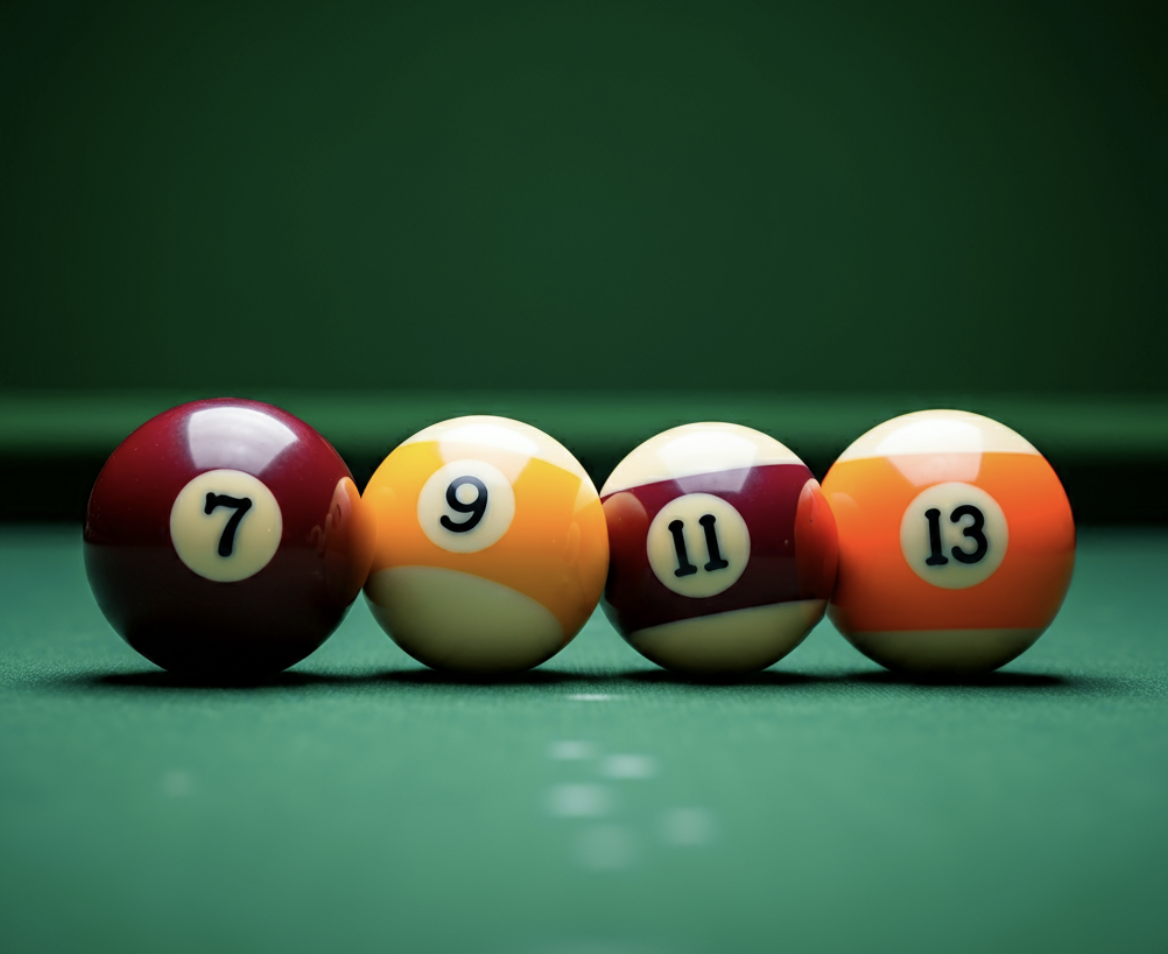

In [16]:
val imageUrl = "https://storage.googleapis.com/generativeai-downloads/images/pool.png"
Image(imageUrl, embed = true).withWidth(300)

Here's a brain teaser based on an image.

> How do I use three of the pool balls to sum up to 30?

It cannot be solved mathematically, let's see how the model respond it.

In [17]:
val textPrompt = "How do I use three of the pool balls to sum up to 30? ONLY using the balls you have!"
val imageData = Image.downloadData(imageUrl)
val imageMimeType = "image/png"

val resp = client.models.generateContent(
    modelName, Content.builder().role("user").parts(
        listOf(
            Part.fromBytes(imageData, imageMimeType),
            Part.builder().text(textPrompt).build()
        )
    ).build(), GenerateContentConfig.builder().build()
)

resp.text()

Here's how to solve this classic riddle using the pool balls in the image:

*   **The Trick:** The trick lies in a simple mathematical adjustment.
*   **Solution:** Re-orient the 9 by rotating to a 6
    *   11 + 13 + 6 = 30

### Use case 2: Create a story book (Text input, Text & Image output)

Gemini models can generate both text and images in response to a prompt. In this example, we'll ask the model to create a children's storybook with both narrative text and accompanying images for each episode. We use the `responseModalities` parameter to specify that we want both text and image outputs.

In [18]:
val prompt = """
Make a children's storybook for age 3-5 about a curious young fox named Mosi, who sets off on a magical adventure through a forest in search of a special star.
The story unfolds over three episodes, with each episode introducing Mosi to a new friend and revealing wondrous and magical landscapes.
For each episode, provide a title, a captivating narrative, and also generate a realistic image illustrating everything in the scene described in the narrative of that episode. Each episode should have less than 100 words.
""".trimIndent()

val stream = client.models.generateContentStream(
    modelName,
    prompt,
    GenerateContentConfig.builder()
        .responseModalities(listOf("TEXT", "IMAGE"))
        .build()
)

// accumulate the content from the stream
var content = ""
stream.forEach { resp ->
    resp.parts()?.forEach { part ->
        if (part.text().isPresent) {
            content += part.text().get().also {
                print(it)
            }
        } else if (part.inlineData().isPresent) {
            content += Image(part.inlineData().get().data().get(), "png").withWidth(400).toHTML().also {
                print(it.take(40) + "..." + it.takeLast(20))
            }
        }
    }
}

## Mosi and the Wishing Star

### Episode 1: The Sparkling Stream

<img src="data:image/png;base64,iVBORw0K...uQmCC" width="400"/>

Mosi, a little fox with a twitchy nose, heard tales of a star that could grant wishes. He set off into the Whispering Woods. Soon, he reached a stream that shimmered with tiny lights. A friendly dragonfly with rainbow wings zipped by. "Have you seen a special star?" Mosi asked. The dragonfly nodded towards a glowing patch of flowers.

### Episode 2: The Singing Meadow

<img src="data:image/png;base64,iVBORw0K...CYII=" width="400"/>

Mosi trotted towards the glowing flowers and found himself in a meadow where the flowers hummed sweet melodies. A fluffy white bunny with sparkly ears nibbled nearby. "Are you looking for the Wishing Star?" she asked, her nose wiggling. Mosi nodded eagerly. The bunny pointed with her ear towards a tall, shimmering tree in the distance.

### Episode 3: The Starry Tree

<img src="data:image/png;base64,iVBORw0K...CYII=" width="400

Mosi and the Wishing Star Episode 1: The Sparkling Stream 
 Mosi, a little fox with a twitchy nose, heard tales of a star that could grant wishes. He set off into the Whispering Woods. Soon, he reached a stream that shimmered with tiny lights. A friendly dragonfly with rainbow wings zipped by. "Have you seen a special star?" Mosi asked. The dragonfly nodded towards a glowing patch of flowers. Episode 2: The Singing Meadow 
 Mosi trotted towards the glowing flowers and found himself in a meadow where the flowers hummed sweet melodies. A fluffy white bunny with sparkly ears nibbled nearby. "Are you looking for the Wishing Star?" she asked, her nose wiggling. Mosi nodded eagerly. The bunny pointed with her ear towards a tall, shimmering tree in the distance. Episode 3: The Starry Tree 
 Mosi reached the shimmering tree. Hanging from its branches was a small, golden star that twinkled brightly. "Hello!" squeaked the star. "I heard you were looking for me." Mosi's eyes widened. He had found the Wishing Star, right here in the magical forest, thanks to his new friends.
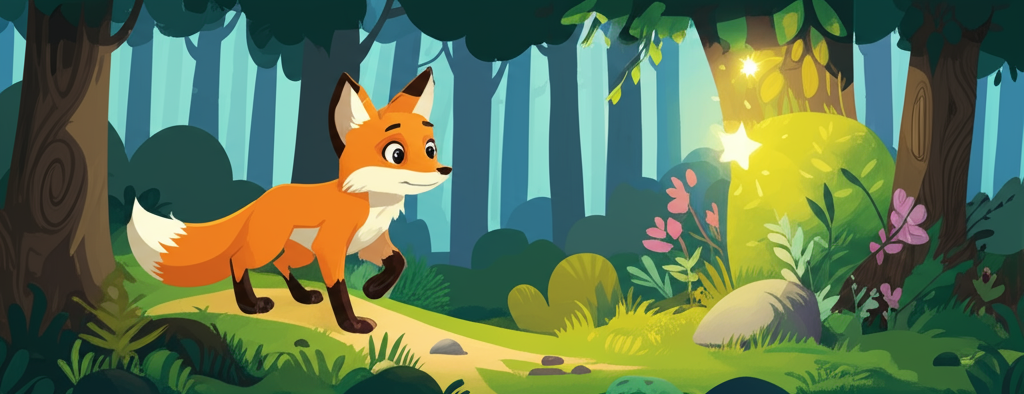
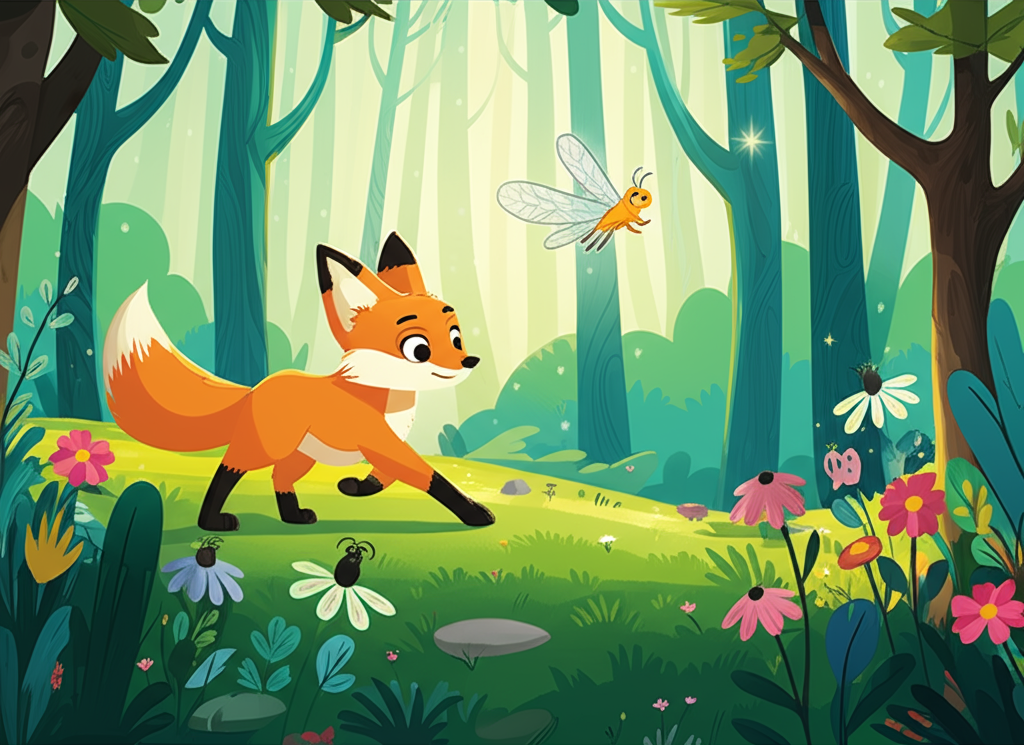
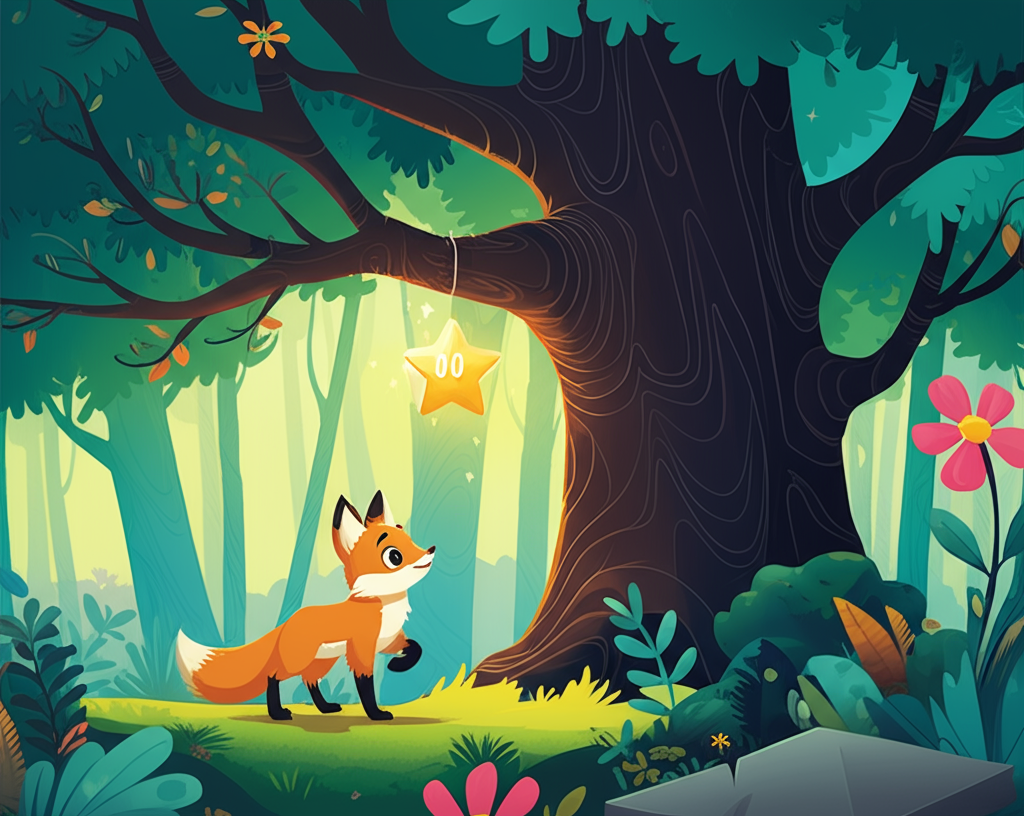

In [19]:
// Display the content in Markdown
DISPLAY(Markdown(content))

### Use case 3: Modify image (Text & Image input, Image output)

Gemini can also modify or transform images based on text instructions. In this example, we'll provide an input image of pool balls and ask the model to change them to volleyballs. The model will generate a new image based on our request while maintaining the overall composition of the original image.


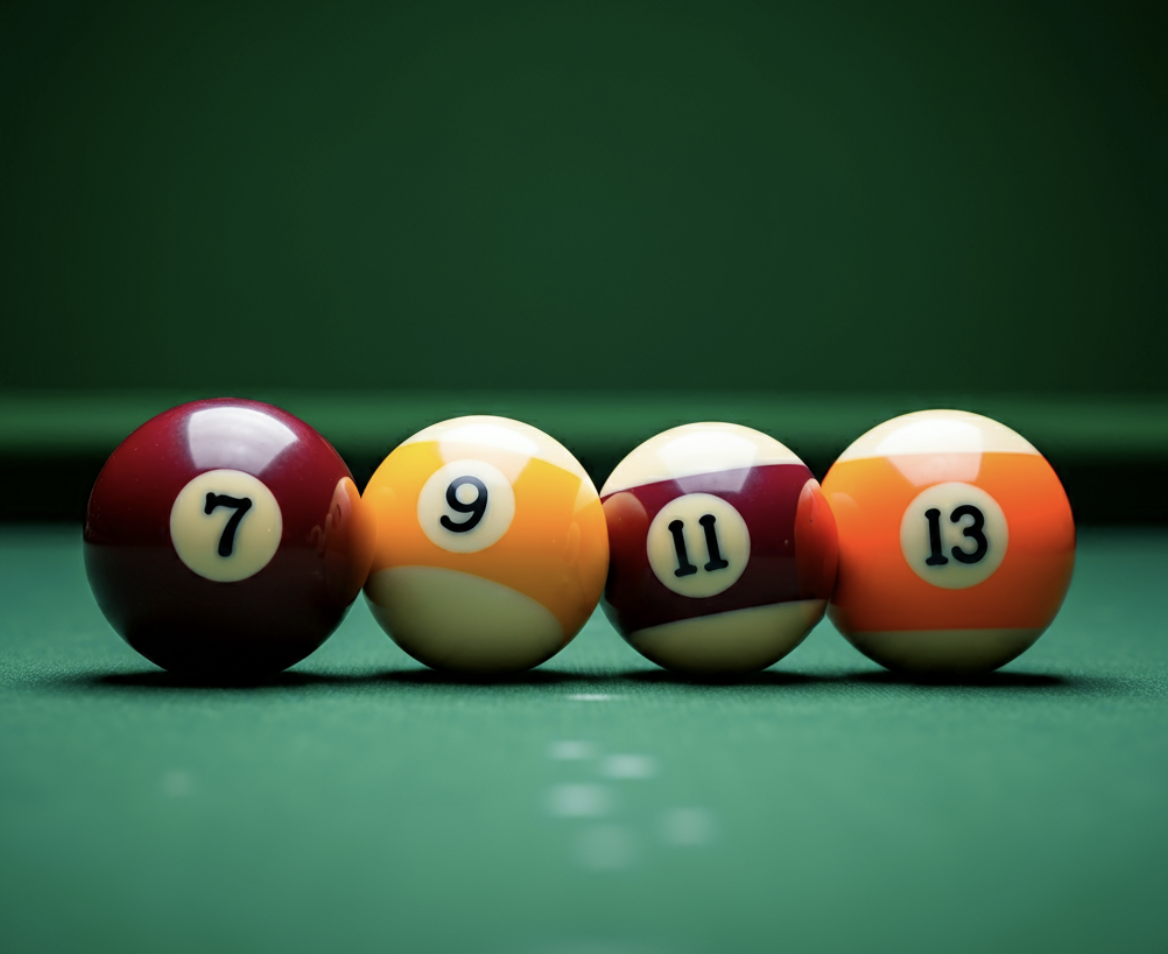

In [13]:
val imageUrl = "https://storage.googleapis.com/generativeai-downloads/images/pool.png"
Image(imageUrl, embed = true).withWidth(300)


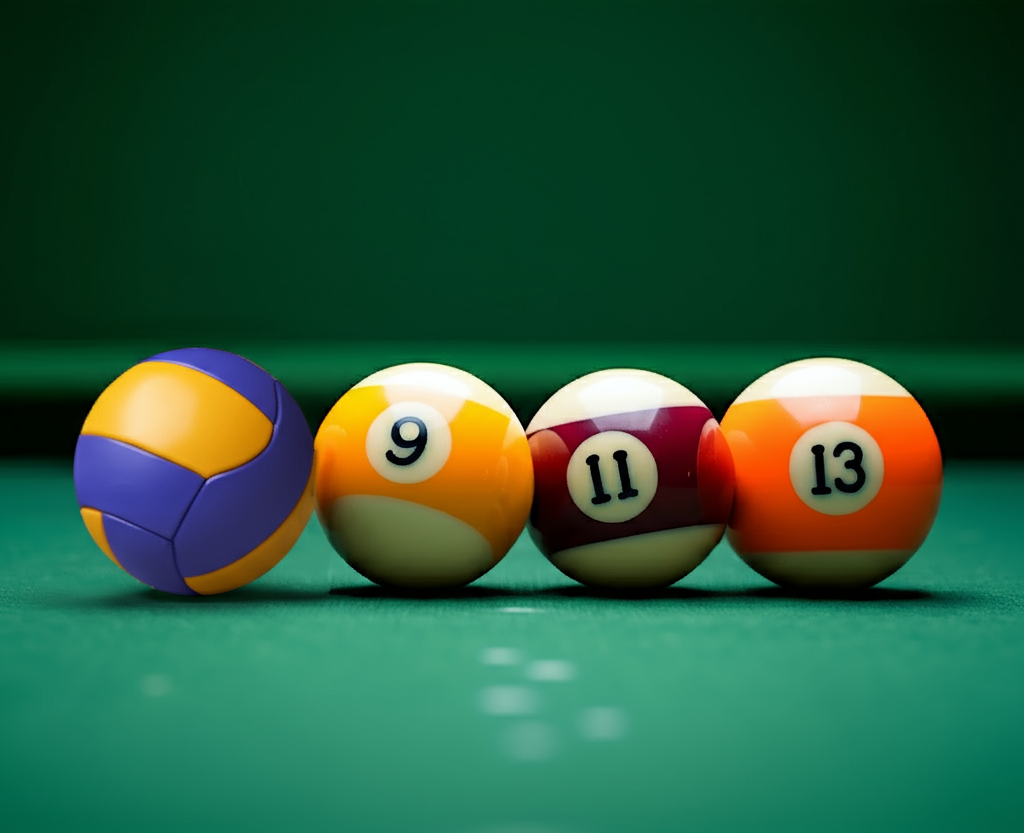

In [38]:
val textPrompt = "Change the 1st ball to volleyball."
val imageData = Image.downloadData(imageUrl)
val imageMimeType = "image/png"

val resp = client.models.generateContent(
    modelName,
    Content.builder().role("user").parts(
        listOf(
            Part.fromBytes(imageData, imageMimeType),
            Part.builder().text(textPrompt).build()
        ),
    ).build(),
    GenerateContentConfig.builder()
        .responseModalities(listOf("TEXT", "IMAGE"))
        .build()
)

DISPLAY(Image(resp.parts()!!.first().inlineData().get().data().get(), "png").withWidth(400))

## Conclusion

In this notebook, we've explored Google's Gemini API using Kotlin. Gemini represents a significant advancement in multimodal AI capabilities, offering powerful features for developers:

- **Text generation**: Create high-quality text content for various applications
- **Streaming responses**: Get real-time responses for interactive applications
- **Multimodal understanding**: Process and reason about text and images together
- **Image generation**: Create and modify images based on text instructions

The Google GenAI Java SDK provides a convenient way to access these capabilities from Kotlin applications. With just a few lines of code, you can integrate advanced AI features into your applications.

### Next Steps

- Explore more advanced prompting techniques
- Try different model parameters to control the output
- Implement chat-based applications using conversation history
- Experiment with more complex multimodal inputs and outputs

For more information, check out the [Google Gemini documentation](https://ai.google.dev/docs) and the [Google GenAI Java SDK](https://github.com/google/generative-ai-java).